In [1]:
### Neural Network Model
### Monthly prediction
## no shuffle of data
### Lookback=35

In [2]:
import sys
sys.path.append('/home/jovyan/work/')
sys.path.append('/home/jovyan/work/src')
sys.path.append('/home/jovyan/work/src/data')
sys.path.append('/home/jovyan/work/src/data_explore')
sys.path.append('/home/jovyan/work/src/features')
sys.path.append('/home/jovyan/work/src/models')
sys.path.append('/home/jovyan/work/src/analysis')


In [3]:
print(sys.path)

['/home/jovyan/work/notebooks', '/opt/conda/lib/python311.zip', '/opt/conda/lib/python3.11', '/opt/conda/lib/python3.11/lib-dynload', '', '/opt/conda/lib/python3.11/site-packages', '/home/jovyan/work/', '/home/jovyan/work/src', '/home/jovyan/work/src/data', '/home/jovyan/work/src/data_explore', '/home/jovyan/work/src/features', '/home/jovyan/work/src/models', '/home/jovyan/work/src/analysis']


In [4]:
from src import data,data_explore,features
from data import create_input_data
from data_explore import explore_util
from features import build_features
from models import train_model,predict_model
from analysis import analyze_pred

In [5]:
def get_jobs_in_range(dfq,start,end):
    df1=dfq.query('submit >= @start and submit < @end')
    return df1

In [6]:
df_arr={}
df_jan = create_input_data.read_data(csv_file_name="../data/processed/lookback35_anon_jan1_feb1.csv", parse_dates_col=[4,5,6])
df_arr['jan'] = df_jan.iloc[77:,]
df_feb_aug = create_input_data.read_data(csv_file_name="../data/processed/lookback35_anon_feb1_aug1.csv", parse_dates_col=[4,5,6])
df_feb = get_jobs_in_range(df_feb_aug,"2022-02-01","2022-03-01")
df_arr['feb']= df_feb.iloc[57:,]
df_arr['march']= get_jobs_in_range(df_feb_aug,"2022-03-01","2022-04-01")
df_arr['april']= get_jobs_in_range(df_feb_aug,"2022-04-01","2022-05-01")
df_arr['may'] = get_jobs_in_range(df_feb_aug,"2022-05-01","2022-06-01")
df_arr['june'] = get_jobs_in_range(df_feb_aug,"2022-06-01","2022-07-01")
df_arr['july'] = get_jobs_in_range(df_feb_aug,"2022-07-01","2022-08-01")

df_aug= create_input_data.read_data(csv_file_name="../data/processed/correct_anon_aug_sept_past2022_35_completed_qm.csv", parse_dates_col=[4,5,6])
df_arr['august'] = df_aug.iloc[48:,]
df_sept = create_input_data.read_data(csv_file_name="../data/processed/lookback35_anon_sept1_oct1.csv", parse_dates_col=[4,5,6])
df_arr['sept']=df_sept.iloc[43:,]
df_oct = create_input_data.read_data(csv_file_name="../data/processed/lookback35_anon_oct1_nov1.csv", parse_dates_col=[4,5,6])
df_arr['oct'] = df_oct.iloc[55:,]
df_nov = create_input_data.read_data(csv_file_name="../data/processed/lookback35_anon_nov1_dec1.csv", parse_dates_col=[4,5,6])
df_arr['nov'] = df_nov.iloc[76:,]

In [7]:
def train_test_data(month):
    X_historydata = df_arr[month]
    ## remove default columns
    df = build_features.remove_default_cols(df_arr[month])
    Y_waittimedata = df['queue_minutes']
    X_historydata= build_features.remove_cols(df,['queue_minutes','run_minutes'])
    return X_historydata, Y_waittimedata

In [10]:
from importlib import reload
reload(train_model)
def train_model_NN(X_historydata_norm, Y_waittimedata_train):
    epochs=500
    batch_size=32
    validation_spilt=0.2
    model = train_model.create_default_model(input_shape=42)
    early_stopping_cb = train_model.set_early_stopping()
    model, hist = train_model.train_model_no_shuffle(X_historydata_norm, Y_waittimedata_train, model, early_stopping_cb,epochs=epochs, batch_size=batch_size, validation_spilt=0.2)
    return model, hist

In [11]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def predict_evaluate(model,scaler,X_historydata_test,Y_waittimedata_test):
    y_pred=model.predict(scaler.transform(X_historydata_test))
    y_pred = np.where(y_pred<0,0,y_pred)
    r2s = r2_score(Y_waittimedata_test.to_numpy(),y_pred)
    mse = mean_squared_error(Y_waittimedata_test.to_numpy(),y_pred,squared=False)
    mae = mean_absolute_error(Y_waittimedata_test.to_numpy(),y_pred)
    return y_pred, r2s, mse, mae

In [12]:
from sklearn.linear_model import LinearRegression
from importlib import reload
import numpy as np
reload(analyze_pred)
reload(build_features)
train_months=['jan','feb','march','april','may','june','july','august','sept','oct']
predict_months=['feb','march','april','may','june','july','august','sept','oct','nov']
results=[]
for i in range(0,10):
    result = {}
    result['train_month']= train_months[i]
    result['predict_month']= predict_months[i]
    X_historydata_train, Y_waittimedata_train = train_test_data(train_months[i])
    X_historydata_test, Y_waittimedata_test = train_test_data(predict_months[i])
    X_historydata_norm, scaler = build_features.standardization(X_historydata_train)
    model, hist = train_model_NN(X_historydata_norm, Y_waittimedata_train)
    y_pred, r2s, mse, mae = predict_evaluate(model,scaler,X_historydata_test,Y_waittimedata_test)
    #provision_time = 20
    provision_time = 45 
    tolerance_factor = 3
    provision_time, n_scheduled, n_missed, no_missed, wrongly_scheduled, t_num = analyze_pred.analysis_short(0,Y_waittimedata_test.shape[0], Y_waittimedata_test, y_pred.ravel(),
                                                                                                          provision_time=provision_time, tolerance_factor=tolerance_factor)
    
    result['ideally_sched'] = n_scheduled
    result['missed'] = n_missed

    result['wrongly_sched'] = wrongly_scheduled
    result['total_num'] = t_num
    result['%_wrongly_sched'] = (wrongly_scheduled/t_num)*100
    result['%_ideally_sched'] = (n_scheduled/t_num)*100
    result['%_missed_oppor.'] = (n_missed/n_scheduled)*100
    result['t_wrong_sched_%'] = (wrongly_scheduled/(wrongly_scheduled + no_missed))*100
    result['r2s'] = r2s
    result['mse'] = mse
    result['mae'] = mae
    result['provision_time'] = provision_time
    #result['model_score'] = model_score
    #result['model'] = lreg
    result['y_pred'] = y_pred
    #result['not_missed'] = no_missed
    #result['provision_time'] = provision_time
    results.append(result)
    #print(result)
    #print("\n")


Model: "queueTime"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden1 (Dense)             (None, 30)                1290      
                                                                 
 Hidden2 (Dense)             (None, 100)               3100      
                                                                 
 Hidden3 (Dense)             (None, 100)               10100     
                                                                 
 Output (Dense)              (None, 1)                 101       
                                                                 
Total params: 14,591
Trainable params: 14,591
Non-trainable params: 0
_________________________________________________________________
None
1125/1125 [==============================] - 0s 401us/step
Model: "queueTime"
_________________________________________________________________
 Layer (type)                Output 

/tmp/ipykernel_96574/2280644773.py:32: RuntimeWarning: invalid value encountered in long_scalars
  result['t_wrong_sched_%'] = (wrongly_scheduled/(wrongly_scheduled + no_missed))*100


In [13]:
reload(analyze_pred)
rdf = analyze_pred.add_all_to_df(results)

In [14]:
rdf

,train_month,predict_month,ideally_sched,missed,wrongly_sched,total_num,%_wrongly_sched,%_ideally_sched,%_missed_oppor.,t_wrong_sched_%,r2s,mse,mae,provision_time,y_pred
0,jan,feb,12846,6283,5504,35986,15.294837,35.697216,48.910167,45.612000,0.005799,790.490739,260.513046,45,"[[56.20254], [56.629448], [57.549618], [58.469..."
1,feb,march,16178,254,18254,44846,40.703742,36.074566,1.570033,53.408625,-0.030804,511.651004,249.538929,45,"[[165.38637], [165.38637], [165.96747], [161.0..."
2,march,april,4253,2287,9018,62427,14.445673,6.812757,53.773807,82.101238,-0.089716,228.862892,64.079195,45,"[[0.0], [16.661493], [177.22853], [177.9329], ..."
3,april,may,1990,1701,417,55544,0.750756,3.582745,85.477387,59.065156,0.037583,257.428800,41.957707,45,"[[0.0], [0.0], [0.0], [0.0], [5.2105885], [0.0..."
4,may,june,7455,2676,8495,57031,14.895408,13.071838,35.895372,63.997288,-0.027329,200.843458,116.189126,45,"[[125.37135], [100.56859], [100.23612], [129.6..."
5,june,july,2840,294,10256,67325,15.233569,4.218344,10.352113,80.112482,0.072072,680.386921,138.352162,45,"[[7.1271653], [4.0303087], [4.0303087], [4.202..."
6,july,august,9041,8584,1072,69753,1.536851,12.961450,94.945249,70.111184,-0.012801,577.508926,139.433343,45,"[[127.90056], [128.11823], [128.33588], [128.5..."
7,august,sept,4056,3983,5251,78865,6.658213,5.142966,98.200197,98.628850,-0.082274,496.812026,106.036868,45,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
8,sept,oct,2895,2779,43,41609,0.103343,6.957629,95.993092,27.044025,0.001900,268.910691,45.641856,45,"[[61.022366], [61.275513], [61.528637], [61.78..."
9,oct,nov,2182,2182,0,55454,0.000000,3.934793,100.000000,NaN,0.018481,111.139373,19.189394,45,"[[24.535124], [26.22014], [26.41239], [26.4139..."


In [15]:
# write to file
from pathlib import Path  
filepath = Path('../data/processed/month_prediction_lookback35_nn_anon_jan-nov22_prov45.csv')  
#filepath.parent.mkdir(parents=True, exist_ok=True)  
rdf.to_csv(filepath,index=False)

Text(0, 0.5, 'Total Number of Wrong Scheduled Jobs')

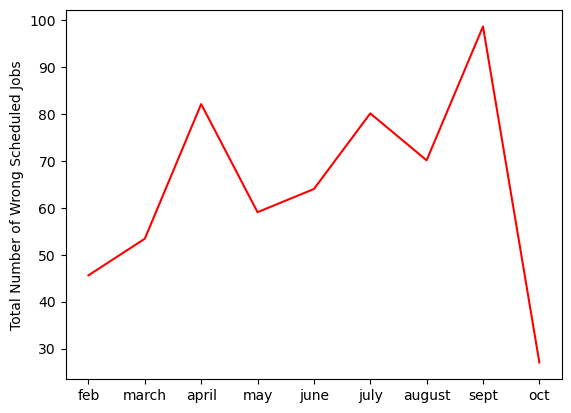

In [16]:
import matplotlib.pyplot as plt
t_wrong_sched= [] 


for i in range(0,10):
    t_wrong_sched.append(results[i]['t_wrong_sched_%'])
plt.plot(predict_months,t_wrong_sched,'r')
plt.ylabel('Total Number of Wrong Scheduled Jobs')

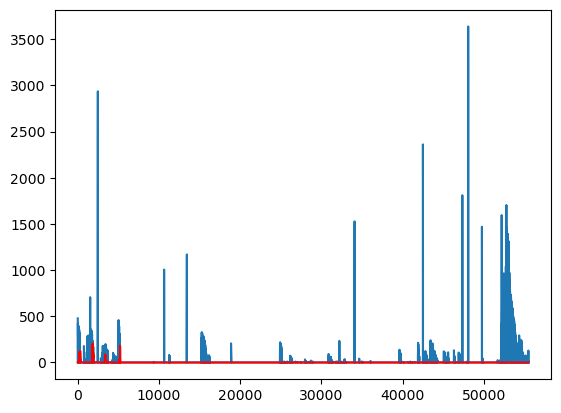

In [58]:
plt.plot(df_arr['nov']['queue_minutes'].to_numpy())
plt.plot(results[9]['y_pred'],'r')

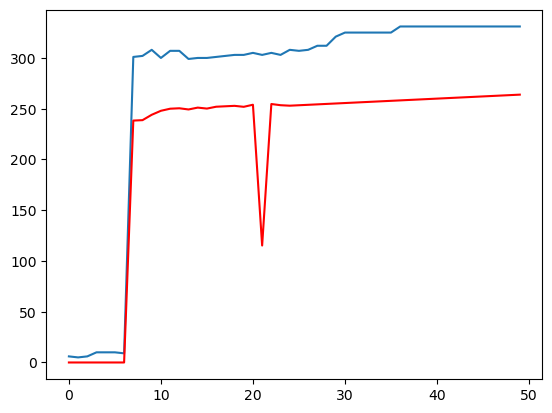

In [41]:

plt.plot(df_arr['april']['queue_minutes'].to_numpy()[150:200])
plt.plot(results[2]['y_pred'][150:200],'r')

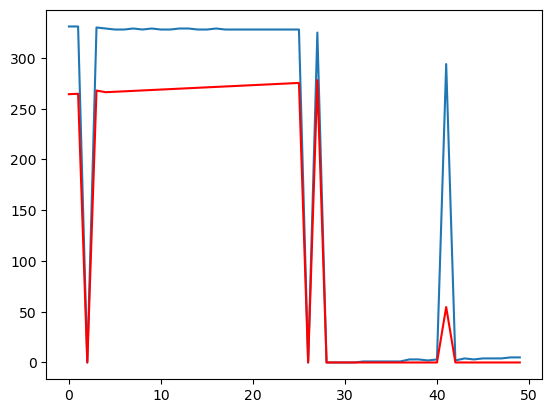

In [42]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[200:250])
plt.plot(results[2]['y_pred'][200:250],'r')

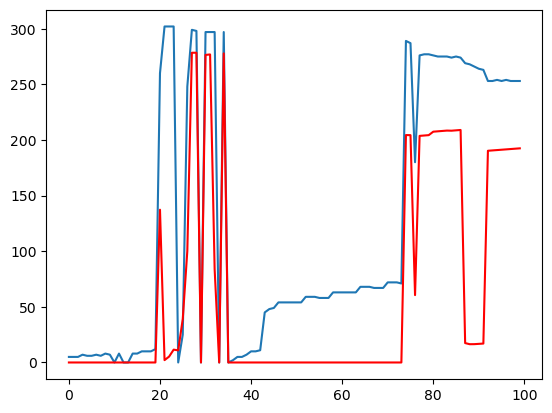

In [43]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[250:350])
plt.plot(results[2]['y_pred'][250:350],'r')

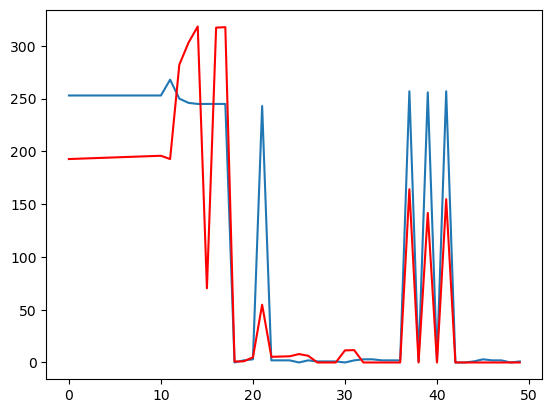

In [44]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[350:400])
plt.plot(results[2]['y_pred'][350:400],'r')

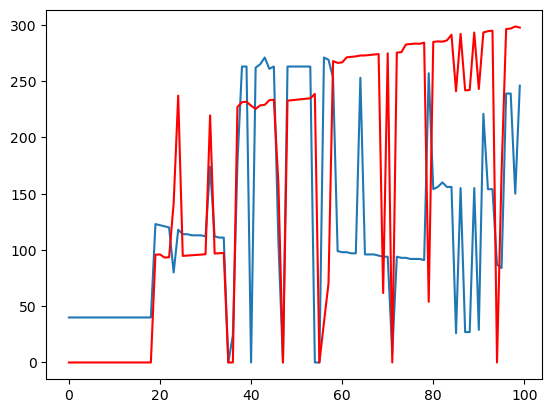

In [45]:
plt.plot(df_arr['april']['queue_minutes'].to_numpy()[1250:1350])
plt.plot(results[2]['y_pred'][1250:1350],'r')